<a href="https://colab.research.google.com/github/yingch08/Digit-Recognizer/blob/main/Project_Kaggle_DigitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Overview**
This is a Kaggle project of building a digit recognizer (Project: https://www.kaggle.com/competitions/digit-recognizer/overview ). 
This notebook includes:  

    Part 1. Data Preprocessing
    Part 2. Model Building (Neural Network)
    Part 3. Visualization

#### **Part 0. Data Import & Environment Setting**

In [ ]:
#Using Kaggle's beta API. 
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle competitions download -c digit-recognizer
!unzip digit-recognizer.zip

 33% 5.00M/15.3M [00:00<00:00, 44.2MB/s]
100% 15.3M/15.3M [00:00<00:00, 104MB/s] 
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# read the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

#### **Part 1. Data Preprocessing**

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
#set a random seed
tf.random.set_seed(20770)

* First we look at the parameters in the data.

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*  We observed that the data provided by Kaggle is different from the data we import from MNIST package.
* Each item is represented by 28*28=784 pixel, each representing a color.

In [ ]:
#Define input as X_train and output as Y_train
X_train = df_train.iloc[:,1:]
X_train1 = df_train.iloc[:,1:] #this will be used for show plots
Y_train = df_train.iloc[:,0]

#Now we output the shape
X_train.shape,Y_train.shape

((42000, 784), (42000,))

* We will have to reshape the data if using a convolutional neural network model because CNN is designed to work with 3 dimensions for every sample. refer:https://datascience.stackexchange.com/questions/60126/data-reshaping-for-cnn-using-keras
* reshape() method:
    * array = array.reshape((n_samples, width, height, n_channels))
    * for color images: n_channels = 3
    * for gray scale images: n_channels = 1

In [ ]:
#reshape data
X_train1 = X_train1.values.reshape(-1,28,28)#plots must be shaped in (28,28) in Colab, but can also use (28,28,1) in Kaggle
X_train = X_train.values.reshape(-1,28,28,1)
test = df_test.values.reshape(-1,28,28,1)

#output shape
X_train1.shape,test.shape

((42000, 28, 28), (28000, 28, 28, 1))

In [ ]:
#Normalize data
X_train = X_train / 255.0
test = df_test / 255.0

* Now plot the image

How many rows of images would you like to review? 2


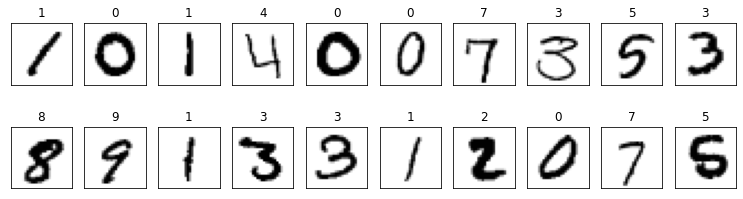

In [ ]:
#Prompt the user "How many rows of training images would you like to review?" and output corresponding number of rows with ten images on each row.
n_cols = 10
n_rows = int(input("How many rows of images would you like to review? "))# enter the row you want

def plot(images, labels, predictions=None):
    # create a grid with 10 columns
    i=1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 3, n_rows + 1.5))# set the distance between blocks
    if predictions is None:
        predictions = [None] * len(labels)
    for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
      if i <= n_cols*n_rows: #run only if index <= row* 10 columns
        i=i+1
        ax = axes.flat[index]
        ax.imshow(x, cmap=plt.cm.binary)
        ax.set_title(y_true)
        if y_pred is not None:
            ax.set_xlabel(class_names[y_pred])
        ax.set_xticks([])
        ax.set_yticks([])

# plot images
plot(X_train1[:(n_rows*n_cols)], Y_train[:((n_rows*n_cols))])

#### **Part 2. Model Building (CNN Model)**

* Reference: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 
* The model with this architechture turned out to be the best performance
 **In -> [[Conv2D->relu]2 -> MaxPool2D -> Dropout]2 -> Flatten -> Dense -> Dropout -> Out**
* convolutional layers: these run input through certain filters, which identify features in the image
    * We use relu as activation. A relu activation stands for “Rectified Linear Units”, which takes the max of a value or zero.
    * Add another convolutional layer
    * Add pooling layer combine convolutional features, helping in feature reduction
    * Add a “dropout” layer to avoid this overfit, 0.25 means randomly drop 25% of the units and their connections during the training process
* flatten layers: these convert an N-dimentional layer to a 1D layer
    * Add a dense hidden layer
    * Add another dropout layer before adding a final dense layer which classifies the data
    * The softmax activation is used for categorical classification, softmax can provide a probability of classification
* output layer
    * We use softmax for categorical classification

In [ ]:
# Set up CNN model
model = keras.Sequential()

# First convolution layer, 32 convolution kernels, size 5x5, convolution mode SAME, activation function Relu, size of input tensor. 5*5 sliding window, extract 32 feature images  
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))

# Pooling layer, pooling core size 2x2, select the maximum value in the convolution layer, fix the eigenvalue, compress the image eigenvalue  
model.add(MaxPool2D(pool_size=(2, 2)))

# Discard a quarter of the network connections randomly to prevent overfitting  
model.add(Dropout(0.25))

#Compared with the feature graph of the first convolution layer, parameter 64 is set  
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

#Compared with the feature graph of the first convolution layer, parameter 64 is set  
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

#Compared with the feature graph of the first convolution layer, parameter 64 is set  
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

# Full connection layer, expand operation. Convert eigenvalues into vectors
model.add(Flatten())

# Add hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

* Now we use the sparse_categorical_crossentropy() loss function to configure the model training method, inform the optimizer, loss function and accuracy criterion used for training. For vector-based dependent variables categorical_crossentropy is the best solution. Set up an optimizer with a given loss function that uses a metric and fits the model using our training data. The ADAM optimizer outperforms other optimizers.
* An epoch is one forward pass and one backward pass of all training examples.We set the epochs to 10, but for better performance it can be 20, but will take more time. Later we will analyse whether it worse taking the time. The batch size is the number of training examples in one forward or backward pass.

In [ ]:
# Fit CNN model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_fit=model.fit(X_train, Y_train, batch_size=60, epochs=30,validation_split=0.2)

Epoch 1/30
560/560 [==============================] - 6s 9ms/step - loss: 0.4542 - accuracy: 0.8493 - val_loss: 0.0952 - val_accuracy: 0.9724
Epoch 2/30
560/560 [==============================] - 5s 8ms/step - loss: 0.1053 - accuracy: 0.9710 - val_loss: 0.0479 - val_accuracy: 0.9860
Epoch 3/30
560/560 [==============================] - 4s 8ms/step - loss: 0.0822 - accuracy: 0.9774 - val_loss: 0.0515 - val_accuracy: 0.9860
Epoch 4/30
560/560 [==============================] - 5s 8ms/step - loss: 0.0694 - accuracy: 0.9816 - val_loss: 0.0395 - val_accuracy: 0.9894
Epoch 5/30
560/560 [==============================] - 4s 8ms/step - loss: 0.0587 - accuracy: 0.9837 - val_loss: 0.0374 - val_accuracy: 0.9892
Epoch 6/30
560/560 [==============================] - 4s 8ms/step - loss: 0.0500 - accuracy: 0.9860 - val_loss: 0.0412 - val_accuracy: 0.9893
Epoch 7/30
560/560 [==============================] - 4s 8ms/step - loss: 0.0508 - accuracy: 0.9857 - val_loss: 0.0438 - val_accuracy: 0.9888
Epoch 

* Evaluate Model

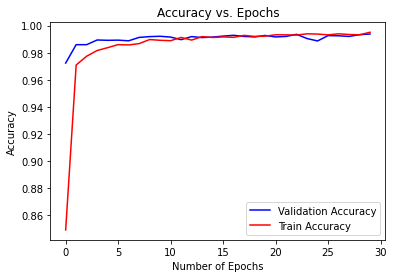

In [ ]:
# Plot the accuracy curves for training and validation 
plt.plot(model_fit.history['val_accuracy'], color='b', label="Validation Accuracy")
plt.plot(model_fit.history['accuracy'], color='r', label="Train Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Plot the Confusion matrix of predict and true label of valid data to see the match of model**

In [ ]:
#define predict label of valid data

#We use validation_split in model fit, so we now need to split the last 20% of original data into validation data manually
num = int(-0.2*len(df_train))
x_val = df_train.iloc[num:,1:].values.reshape(-1,28,28,1)

#Now predcit the valid data label
y_pred = model.predict(x_val)
y_pred_label = np.argmax(y_pred, 1) 

#define true label of valid data
y_true = df_train.iloc[num:,0].values
y_true

array([0, 7, 7, ..., 7, 6, 9])

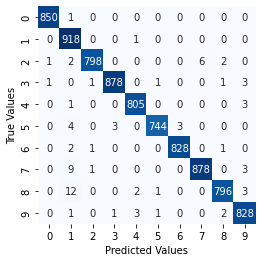

In [ ]:
#Confusion matrix
cf = confusion_matrix(y_true, y_pred_label) 

#Plot Confusion matrix
sns.heatmap(cf.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show()

**Predict on test data**

In [ ]:
# predict results
test = df_test.values.reshape(-1,28,28,1)
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


####**Part 3. Visualization**

Which number from 0 to 28000 do you like ? 12
The predict is 4


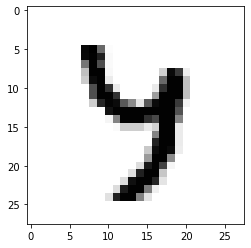

In [ ]:
#Input a number
in_put=int(input("Which number from 0 to 28000 do you like ? "))
image_index = in_put

#Show the image of the input index in test data
plt.imshow(test[image_index].reshape(28, 28),cmap='Greys')
predict = test[image_index].reshape(28,28)
pred = model.predict(test[image_index].reshape(1, 28, 28, 1))
print("The predict is",pred.argmax())

In [ ]:
from google.colab import files
submission.to_csv("737_v1.csv",index=False)
files.download('737_v1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>